<a href="https://colab.research.google.com/github/tristontan/StatSmith/blob/main/DSA3101_Data_Cleaning_(A)_Opt_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Adjust viewing of data

In [ ]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 30)

## Import libraries and data

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=4fea925130fa1c47a4cabe4bac8140ca25e8d3a7ccda66cccfce837659f61a0b
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
# import libraries
import pandas as pd
import numpy as np
from langdetect import detect, DetectorFactory

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
import spacy
from multiprocessing import Pool

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # import trip advisor data (with sentiment analysis)
# ta_sa = pd.read_csv('/content/drive/MyDrive/DSA3101 Data/Subgroup A/Edited_SentimentAnalysisBelle.csv')
# ta_sa.head()

### Trip Advisor

In [ ]:
ta1 = pd.read_excel('/content/drive/MyDrive/DSA3101 Data/Raw Data/dataset_tripadvisor-reviews_2024.xlsx')
ta1.head()

KeyboardInterrupt: 

In [ ]:
ta2 = pd.read_csv('/content/drive/MyDrive/DSA3101 Data/Raw Data/2_dataset_tripadvisor-reviews_2024-2.csv')
ta2.head()

In [ ]:
def process_tripadvisor(data):
    # Specify columns to keep and rename them
    columns_keep = ['helpfulVotes', 'id', 'publishedDate', 'publishedPlatform',
                    'rating', 'text', 'title', 'travelDate', 'tripType', 'user/name', 'user/userLocation/name']
    data = data[columns_keep]
    data = data.rename(columns={
        'publishedDate': 'reviewDate',
        'user/name': 'username',
        'user/userLocation/name': 'userLocation'
    })

    # Handle userLocation (split into state and country if there's a comma)
    data[['state', 'country']] = data['userLocation'].apply(
        lambda x: pd.Series(x.split(', ', -1)) if pd.notna(x) and ', ' in x else pd.Series([None, x])
    )
    data['state'] = data['state'].str.strip()
    data['country'] = data['country'].str.strip()

    # Change data types
    data['reviewDate'] = pd.to_datetime(data['reviewDate']).dt.date
    data['travelDate'] = pd.to_datetime(data['travelDate'], format='%Y-%m').dt.date

    data['hnnMention'] = (data['title'] + ' ' + data['text']).apply(lambda x: bool(
        pd.Series(x).str.contains(r'\bhalloween horror night|halloweenhorrornight|hnn\b', case=False, na=False).any()))

    return data

In [ ]:
ta1 = process_tripadvisor(ta1)
ta1.head()

In [ ]:
ta2 = process_tripadvisor(ta2)
ta2.head()

In [ ]:
ta = pd.concat([ta1, ta2], ignore_index=True)
ta

In [ ]:
hnn_true_count = ta['hnnMention'].sum()
print(f"Number of TripAdvisor HNN mentions: {hnn_true_count}")

### Instagram

In [ ]:
ig = pd.read_excel('/content/drive/MyDrive/DSA3101 Data/Raw Data/dataset_instagram-hashtag-scraper_2024.xlsx')
ig.head()

Upon examining the excel file scrapped, we realise that all profiles are not private (i.e. public), all has_liked are false, no comment count was recorded, and media_type refers to product_type.

In [ ]:
import datetime

def process_instagram(data):
    # Specify columns to keep and rename them
    columns_keep = ['caption', 'id', 'is_paid_partnership', 'like_count',
                    'media_type', 'timestamp', 'user/pk']
    data = data[columns_keep]
    data = data.rename(columns={
        'timestamp': 'publishDate',
        'media_type	': 'postType',
        'user/pk': 'user_id'
    })

    # Convert publishDate to retrieve just the date
    data['publishDate'] = data['publishDate'].apply(lambda timestamp: datetime.datetime.utcfromtimestamp(timestamp).date())

    # strip
    data['caption'] = data['caption'].astype(str).str.strip()

    data['hnnMention'] = data['caption'].apply(lambda x: bool(
        pd.Series(x).str.contains(r'\bhalloween horror night|halloweenhorrornight|hnn\b', case=False, na=False).any()))

    return data

In [ ]:
ig = process_instagram(ig)
ig

In [ ]:
hnn_true_count = ig['hnnMention'].sum()
print(f"Number of Instagram HNN mentions: {hnn_true_count}")

### Reddit

Scraped using ASYNCPRAW

In [ ]:
red = pd.read_excel('/content/drive/MyDrive/DSA3101 Data/Raw Data/Reddit_Scrape.xlsx')
red.head()

In [ ]:
import datetime

def process_reddit(data):
    # Specify columns to keep and rename them
    columns_keep = ['score', 'id', 'num_comments', 'created',
                    'title', 'body']
    data = data[columns_keep]
    data = data.rename(columns={
        'created': 'publishDate',
        'body': 'text'
    })

    # Convert publishDate to retrieve just the date
    data['publishDate'] = pd.to_datetime(data['publishDate']).dt.date  # Using .dt.date to extract date part

    # strip
    data['title'] = data['title'].astype(str).str.strip()
    data['text'] = data['text'].astype(str).str.strip()

    data['hnnMention'] = (data['title'] + ' ' + data['text']).apply(lambda x: bool(
        pd.Series(x).str.contains(r'\bhalloween horror night|halloweenhorrornight|hnn\b', case=False, na=False).any()))

    return data

In [ ]:
red = process_reddit(red)
red

In [ ]:
hnn_true_count = red['hnnMention'].sum()
print(f"Number of Reddit HNN mentions: {hnn_true_count}")

## Sentiment Analysis

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.3 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    compound_score = scores['compound']

    # # Define thresholds
    # if compound_score >= 0.05:
    #     sentiment = 1  # Positive
    # elif compound_score <= -0.05:
    #     sentiment = -1  # Negative
    # else:
    #     sentiment = 0  # Neutral

    return compound_score

# sentiment = get_sentiment("THIS IS SO HORRIBLE NEVER COME HERE!!!")
# print(sentiment)  # Outputs a dictionary with compound, pos, neu, and neg scores

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_sentiment(data, sentiment_column):
    """
    This function plots the sentiment distribution as a histogram.

    Parameters:
    data (DataFrame): The DataFrame containing the sentiment data.
    sentiment_column (str): The name of the column containing sentiment values.
    """
    sns.histplot(data[sentiment_column], kde=False, color='blue', bins=20)

    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')

    plt.show()

## Perform Sentiment Analysis

### TripAdvisor

In [ ]:
ta_df = ta.copy()
ta_df['sentiment'] = (ta_df['title'] + ' ' + ta_df['text']).apply(get_sentiment)
ta_df

,helpfulVotes,id,reviewDate,publishedPlatform,rating,text,title,travelDate,tripType,username,userLocation,state,country,hnnMention,sentiment
0,0,971639422,2024-09-27,MOBILE,5,We opted for the VIP tour this visit. We weren...,SO MUCH FUN!! VIP PACKAGE,2024-09-01,FAMILY,kirstylee88,"Brisbane, Australia",Brisbane,Australia,False,0.9915
1,0,970932012,2024-09-22,OTHER,4,"Что сказать, в парке юниверсал я был в первые,...",Водный мир,2024-03-01,SOLO,Юрий,"Vladivostok, Russia",Vladivostok,Russia,False,0.0000
2,0,970806594,2024-09-22,MOBILE,4,"The place is extremely good, but there's long ...",Good experience,2024-09-01,FAMILY,George J,"Kochi (Cochin), India",Kochi (Cochin),India,False,0.7748
3,0,970343257,2024-09-18,MOBILE,4,We had a really lovely day at Universal Studio...,"Wonderful day out, a well needed change to th...",2024-09-01,FAMILY,The Palmers,"San Francisco, California",San Francisco,California,False,0.9445
4,0,970207042,2024-09-17,OTHER,1,The staff in Singapore no active like Japan or...,Bad experience,2024-08-01,FAMILY,Nayafa H,NaN,NaN,NaN,False,-0.7825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6372,0,972475765,2024-10-03,MOBILE,4,I personally had a very good experience at Uni...,One of my Singapore favourites!,2024-10-01,FAMILY,Abby M,NaN,NaN,NaN,False,0.9745
6373,0,972385867,2024-10-03,OTHER,5,Wonderful experience and always the tough time...,Wonderful Experience!,2024-08-01,FRIENDS,Prakash_Jay,"Chennai (Madras), India",Chennai (Madras),India,False,0.9371
6374,6,972016845,2024-09-30,MOBILE,4,So many people and large queues (visited on a ...,Fun day out,2024-09-01,COUPLES,Belinda8,"Hobart, Australia",Hobart,Australia,False,0.2751
6375,0,971905596,2024-09-29,MOBILE,4,I recently spent an exhilarating day at Univer...,A Day at Universal Studios,2024-09-01,FAMILY,Alhanouf,"Riyadh, Saudi Arabia",Riyadh,Saudi Arabia,False,0.9948


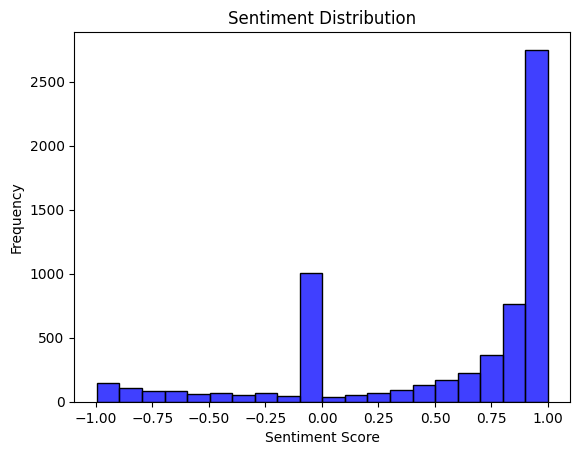

In [ ]:
plot_sentiment(ta_df, 'sentiment')

Already exported, commenting out to avoid exporting duplicates

In [ ]:
# excel_file_name = "TripAdvisor Sentiment.xlsx"
# excel_folder_path = '/content/drive/MyDrive/DSA3101 Data/Subgroup A/(A) Q1 Optional/Sentiment Data/'

# ta_df.to_excel(excel_folder_path + excel_file_name, index=False)  # exclude index
# print(f"Exported data to {excel_folder_path + excel_file_name}")

Exported data to /content/drive/MyDrive/DSA3101 Data/Subgroup A/(A) Q1 Optional/Data/TripAdvisor Sentiment.xlsx


### Instagram

In [ ]:
ig_df = ig.copy()
ig_df['sentiment'] = (ig_df['caption']).apply(get_sentiment)
ig_df

,caption,id,is_paid_partnership,like_count,media_type,publishDate,user_id,hnnMention,sentiment
0,So happy to be back!!! Had so much fun with KA...,3394601796424511531_50061029816,False,2436,8,2024-06-20,50061029816,False,0.8989
1,Slay ❤️‍ #revellers #raveoutfit #netherland #s...,3491250038624993738_1931536488,False,24,8,2024-10-31,1931536488,True,0.0000
2,#universalstudios #universalstudiossingapore #...,3485824101472909608_8405629994,False,15,1,2024-10-24,8405629994,False,0.0000
3,#universalstudiossingapore Where discovery nev...,3463971291278226159_3076316567,False,85,1,2024-09-24,3076316567,False,0.0000
4,"Eat, drink & be scary! Still managed to visit ...",3493083653226553887_232999904,False,3,8,2024-11-03,232999904,True,0.1007
...,...,...,...,...,...,...,...,...,...
19870,#universalstudios #universalstudiossingapore #...,3478689500132650910_8405629994,False,9,8,2024-10-14,8405629994,False,0.0000
19871,#universalstudios #universalstudiossingapore #...,3403934235995340138_8405629994,False,3,1,2024-07-03,8405629994,False,0.0000
19872,#universalstudios #universalstudiossingapore #...,3485266011946158773_8405629994,False,11,1,2024-10-23,8405629994,False,0.0000
19873,#universalstudios #universalstudiossingapore #...,3414919181647925088_8405629994,False,19,1,2024-07-18,8405629994,False,0.0000


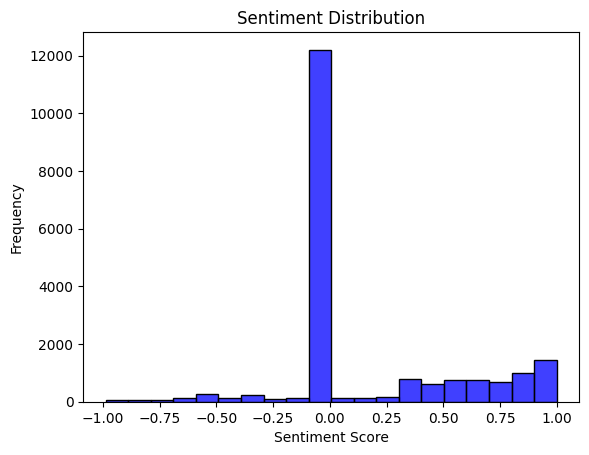

In [ ]:
plot_sentiment(ig_df, 'sentiment')

Already exported, commenting out to avoid exporting duplicates

In [ ]:
# excel_file_name = "Instagram Sentiment.xlsx"
# excel_folder_path = '/content/drive/MyDrive/DSA3101 Data/Subgroup A/(A) Q1 Optional/Sentiment Data/'

# ig_df.to_excel(excel_folder_path + excel_file_name, index=False)  # exclude index
# print(f"Exported data to {excel_folder_path + excel_file_name}")

Exported data to /content/drive/MyDrive/DSA3101 Data/Subgroup A/(A) Q1 Optional/Data/Instagram Sentiment.xlsx


### Reddit

In [ ]:
red_df = red.copy()
red_df['sentiment'] = (red_df['title'] + ' ' + red_df['text']).apply(get_sentiment)
red_df

,score,id,num_comments,publishDate,title,text,hnnMention,sentiment
0,336,zukalj,124,2022-12-24,Is Universal Studios Singapore worth going now...,Anyone knows what’s going on with USS? People ...,False,-0.7319
1,0,1fgi8to,12,2024-09-14,Is Universal Studios Singapore worth visiting ...,I am planning to visit Singapore this December...,False,0.6918
2,1,1fi11qs,16,2024-09-16,Is Universal Studios worth it?,I am planning a family trip to Singapore next ...,False,0.4662
3,1,1ergqbj,4,2024-08-13,Universal Studios Singapore tickets,"Hello everyone,\n\nMy wife and I have planned ...",False,0.8254
4,70,79e4hy,71,2017-10-29,Universal Studio Singapore Tips&hacks,Share your tips or hacks in Universal Studio a...,False,0.8356
...,...,...,...,...,...,...,...,...
99995,0,17b6r6p,0,2023-10-19,Water World Full Show at Universal Studios Sin...,nan,False,0.0000
99996,2,16mob87,1,2023-09-19,Singapore Universal Studios Express pass?,"Hello,\nI will be visiting Singapore in Novemb...",False,0.5820
99997,441,a3g1bz,10,2018-12-05,Abel & Bella at Universal Studios in Singapore 🌎🎢,nan,False,0.0000
99998,5,16bc8jc,1,2023-09-06,Universal Studios Singapore Signage (December ...,nan,False,0.0000


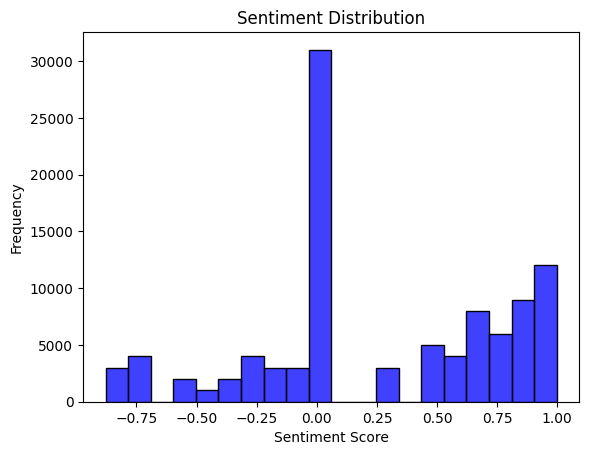

In [ ]:
plot_sentiment(red_df, 'sentiment')

Already exported, commenting out to avoid exporting duplicates

In [ ]:
excel_file_name = "Reddit Sentiment.xlsx"
excel_folder_path = '/content/drive/MyDrive/DSA3101 Data/Subgroup A/(A) Q1 Optional/Sentiment Data/'

red_df.to_excel(excel_folder_path + excel_file_name, index=False)  # exclude index
print(f"Exported data to {excel_folder_path + excel_file_name}")

Exported data to /content/drive/MyDrive/DSA3101 Data/Subgroup A/(A) Q1 Optional/Sentiment Data/Reddit Sentiment.xlsx


## Data-preprocessing

### Drop non-english texts

- large dataset, for nlp pipeline, just import

In [ ]:
# DetectorFactory.seed = 0  # set seed to ensure consistency

# def is_english(text):
#     """Detects if the given text is in English."""
#     try:
#         language = detect(text)
#         return language == 'en'
#     except:
#         return False  # In case of any issues with detection

# def apply_language_detection(data, column):
#     """Applies language detection to multiple columns of text data."""
#     data[column].apply(is_english)
#     return data

In [ ]:
!pip install fasttext
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=3e8056a61e8953ced1dd4e68249a2508b3e86d584ce15c09084b6cf92bf78b48
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [ ]:
import pandas as pd
import langid
from langdetect import detect
import re

def preprocess_text(text):
    """Preprocesses the text to remove noise (like excessive punctuation) and standardize it."""
    text = text.strip()
    text = re.sub(r'[^\w\s!?.]', '', text)  # Remove special characters except for punctuation
    text = re.sub(r'[!?.]{2,}', '!', text)  # Replace repeated punctuation with a single one (e.g., "WOW!!!" -> "WOW!")
    text = text.lower()  # Convert to lowercase
    return text

def detect_language(text):
    """Detect language using multiple methods and return True if English, False otherwise."""
    try:
        cleaned_text = preprocess_text(text)

        # Using langid
        langid_pred = langid.classify(cleaned_text)[0]

        # Using langdetect
        langdetect_pred = detect(cleaned_text)

        # Majority voting for final prediction (True if English, False if not)
        predictions = [langid_pred, langdetect_pred]
        return max(set(predictions), key = predictions.count) == 'en'  # Return True if English, False if not
    except Exception as e:
        # print(f"Error detecting language: {e}")
        return False  # In case of any errors, return False (not English)

def apply_language_detection(data, text_columns):
    """Applies language detection to multiple columns of text data."""
    for column in text_columns:
        data[f'is_english_{column}'] = data[column].apply(detect_language)
    return data

**TripAdvisor**

In [ ]:
ta_df2 = ta_df.copy()
ta_df2 = apply_language_detection(ta_df2, ['title', 'text'])

In [ ]:
ta_df2.loc[(ta_df2['is_english_text'] == False) & (ta_df2['is_english_title'] == False)]
print(len(ta_df2.loc[(ta_df2['is_english_text'] == False) & (ta_df2['is_english_title'] == False)])) # 1135

1135


In [ ]:
# Drop rows directly by specifying the condition in the index
ta_df2.drop(ta_df2[(ta_df2['is_english_text'] == False) & (ta_df2['is_english_title'] == False)].index, inplace=True)
ta_df2.head()

,helpfulVotes,id,reviewDate,publishedPlatform,rating,text,title,travelDate,tripType,username,userLocation,state,country,hnnMention,sentiment,is_english_title,is_english_text
0,0,971639422,2024-09-27,MOBILE,5,We opted for the VIP tour this visit. We weren...,SO MUCH FUN!! VIP PACKAGE,2024-09-01,FAMILY,kirstylee88,"Brisbane, Australia",Brisbane,Australia,False,0.9915,True,True
2,0,970806594,2024-09-22,MOBILE,4,"The place is extremely good, but there's long ...",Good experience,2024-09-01,FAMILY,George J,"Kochi (Cochin), India",Kochi (Cochin),India,False,0.7748,True,True
3,0,970343257,2024-09-18,MOBILE,4,We had a really lovely day at Universal Studio...,"Wonderful day out, a well needed change to th...",2024-09-01,FAMILY,The Palmers,"San Francisco, California",San Francisco,California,False,0.9445,True,True
4,0,970207042,2024-09-17,OTHER,1,The staff in Singapore no active like Japan or...,Bad experience,2024-08-01,FAMILY,Nayafa H,NaN,NaN,NaN,False,-0.7825,True,True
5,0,970001063,2024-09-16,MOBILE,5,I went with my younger siblings and we were al...,Playing at Universal Studios Singapore was a b...,2023-12-01,FAMILY,Ashley,"Jakarta, Indonesia",Jakarta,Indonesia,False,0.9792,True,True


In [ ]:
ta_df2.loc[(ta_df2['is_english_text'] == False) | (ta_df2['is_english_title'] == False)]

,helpfulVotes,id,reviewDate,publishedPlatform,rating,text,title,travelDate,tripType,username,userLocation,state,country,hnnMention,sentiment,is_english_title,is_english_text
10,0,969362566,2024-09-11,OTHER,1,I just bought some uss e tickets online from t...,Universal studios singapore - bad customer care,2024-09-01,FAMILY,Sharon,Malaysia,None,Malaysia,False,0.1280,False,True
24,0,966031539,2024-08-21,OTHER,4,VERY FUN EXPERIENCE WILL BE BACK AGAIN.... Th...,ENJOYABLE,2024-07-01,FAMILY,SunwooKim,South Korea,None,South Korea,False,0.8688,False,True
29,1,965558323,2024-08-18,MOBILE,1,Extremely overcrowded with long wait lines man...,Disappointed universal studios Singapore customer,2024-08-01,COUPLES,Adam M,NaN,NaN,NaN,False,-0.5984,False,True
30,0,965222122,2024-08-16,MOBILE,2,It’s the smallest Universal Studio ever visite...,Smallest Universal Studio visited,2024-08-01,FAMILY,John Hui,NaN,NaN,NaN,False,-0.1027,False,True
32,1,964970878,2024-08-15,OTHER,5,We visited the famous universal studios in Sin...,Universal studios,2024-08-01,FAMILY,Devendra G,India,None,India,False,-0.2263,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6363,0,977361417,2024-10-30,OTHER,1,Service experience is literally zero out of te...,Poor service experience at Sentosa singapore,2024-10-01,FAMILY,Climber07106178994,NaN,NaN,NaN,False,-0.8357,False,True
6365,0,973887783,2024-10-14,OTHER,4,Decided to leave the little one to the care of...,Universal Studios Singapore Experience,2024-09-01,COUPLES,Franz Lowell L,"Manila, Philippines",Manila,Philippines,False,0.9476,False,True
6368,0,972871430,2024-10-06,MOBILE,1,"If you want to spend a lot of money queuing , ...",Over priced. Long queues,2024-10-01,FAMILY,LizTAuckland_,"Bondi Junction, Australia",Bondi Junction,Australia,False,-0.5050,False,True
6374,6,972016845,2024-09-30,MOBILE,4,So many people and large queues (visited on a ...,Fun day out,2024-09-01,COUPLES,Belinda8,"Hobart, Australia",Hobart,Australia,False,0.2751,False,True


In [ ]:
# drop language checking columns
ta_df2 = ta_df2.loc[(ta_df2['is_english_text'] == False) | (ta_df2['is_english_title'] == False)].iloc[: , :-2] # drop language checking column
ta_df2

,helpfulVotes,id,reviewDate,publishedPlatform,rating,text,title,travelDate,tripType,username,userLocation,state,country,hnnMention,sentiment
10,0,969362566,2024-09-11,OTHER,1,I just bought some uss e tickets online from t...,Universal studios singapore - bad customer care,2024-09-01,FAMILY,Sharon,Malaysia,None,Malaysia,False,0.1280
24,0,966031539,2024-08-21,OTHER,4,VERY FUN EXPERIENCE WILL BE BACK AGAIN.... Th...,ENJOYABLE,2024-07-01,FAMILY,SunwooKim,South Korea,None,South Korea,False,0.8688
29,1,965558323,2024-08-18,MOBILE,1,Extremely overcrowded with long wait lines man...,Disappointed universal studios Singapore customer,2024-08-01,COUPLES,Adam M,NaN,NaN,NaN,False,-0.5984
30,0,965222122,2024-08-16,MOBILE,2,It’s the smallest Universal Studio ever visite...,Smallest Universal Studio visited,2024-08-01,FAMILY,John Hui,NaN,NaN,NaN,False,-0.1027
32,1,964970878,2024-08-15,OTHER,5,We visited the famous universal studios in Sin...,Universal studios,2024-08-01,FAMILY,Devendra G,India,None,India,False,-0.2263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6363,0,977361417,2024-10-30,OTHER,1,Service experience is literally zero out of te...,Poor service experience at Sentosa singapore,2024-10-01,FAMILY,Climber07106178994,NaN,NaN,NaN,False,-0.8357
6365,0,973887783,2024-10-14,OTHER,4,Decided to leave the little one to the care of...,Universal Studios Singapore Experience,2024-09-01,COUPLES,Franz Lowell L,"Manila, Philippines",Manila,Philippines,False,0.9476
6368,0,972871430,2024-10-06,MOBILE,1,"If you want to spend a lot of money queuing , ...",Over priced. Long queues,2024-10-01,FAMILY,LizTAuckland_,"Bondi Junction, Australia",Bondi Junction,Australia,False,-0.5050
6374,6,972016845,2024-09-30,MOBILE,4,So many people and large queues (visited on a ...,Fun day out,2024-09-01,COUPLES,Belinda8,"Hobart, Australia",Hobart,Australia,False,0.2751


In [ ]:
# excel_file_name = "TripAdvisor En_Sentiment.xlsx"
# excel_folder_path = '/content/drive/MyDrive/DSA3101 Data/Subgroup A/(A) Q1 Optional/Only English Data/'

# ta_df2.to_excel(excel_folder_path + excel_file_name, index=False)  # exclude index
# print(f"Exported data to {excel_folder_path + excel_file_name}")

Exported data to /content/drive/MyDrive/DSA3101 Data/Subgroup A/(A) Q1 Optional/Only English Data/TripAdvisor En_Sentiment.xlsx


**Instagram**

In [ ]:
ig_df2 = ig_df.copy()
ig_df2 = apply_language_detection(ig_df2, ['caption'])

In [ ]:
ig_df2.loc[(ig_df2['is_english_caption'] == False)]
print(len(ig_df2.loc[(ig_df2['is_english_caption'] == False)]))

4323


In [ ]:
# Drop rows directly by specifying the condition in the index
ig_df2.drop(ig_df2[(ig_df2['is_english_caption'] == False)].index, inplace=True)
ig_df2.head()

,caption,id,is_paid_partnership,like_count,media_type,publishDate,user_id,hnnMention,sentiment,is_english_caption
0,So happy to be back!!! Had so much fun with KA...,3394601796424511531_50061029816,False,2436,8,2024-06-20,50061029816,False,0.8989,True
1,Slay ❤️‍ #revellers #raveoutfit #netherland #s...,3491250038624993738_1931536488,False,24,8,2024-10-31,1931536488,True,0.0000,True
2,#universalstudios #universalstudiossingapore #...,3485824101472909608_8405629994,False,15,1,2024-10-24,8405629994,False,0.0000,True
3,#universalstudiossingapore Where discovery nev...,3463971291278226159_3076316567,False,85,1,2024-09-24,3076316567,False,0.0000,True
4,"Eat, drink & be scary! Still managed to visit ...",3493083653226553887_232999904,False,3,8,2024-11-03,232999904,True,0.1007,True


In [ ]:
# drop language checking columns
ig_df2 = ig_df2[ig_df2['is_english_caption'] == True].iloc[: , :-1] # drop language checking column
ig_df2.head()

,caption,id,is_paid_partnership,like_count,media_type,publishDate,user_id,hnnMention,sentiment
0,So happy to be back!!! Had so much fun with KA...,3394601796424511531_50061029816,False,2436,8,2024-06-20,50061029816,False,0.8989
1,Slay ❤️‍ #revellers #raveoutfit #netherland #s...,3491250038624993738_1931536488,False,24,8,2024-10-31,1931536488,True,0.0000
2,#universalstudios #universalstudiossingapore #...,3485824101472909608_8405629994,False,15,1,2024-10-24,8405629994,False,0.0000
3,#universalstudiossingapore Where discovery nev...,3463971291278226159_3076316567,False,85,1,2024-09-24,3076316567,False,0.0000
4,"Eat, drink & be scary! Still managed to visit ...",3493083653226553887_232999904,False,3,8,2024-11-03,232999904,True,0.1007


In [ ]:
# excel_file_name = "Instagram En_Sentiment.xlsx"
# excel_folder_path = '/content/drive/MyDrive/DSA3101 Data/Subgroup A/(A) Q1 Optional/Only English Data/'

# ig_df2.to_excel(excel_folder_path + excel_file_name, index=False)  # exclude index
# print(f"Exported data to {excel_folder_path + excel_file_name}")

Exported data to /content/drive/MyDrive/DSA3101 Data/Subgroup A/(A) Q1 Optional/Only English Data/Instagram En_Sentiment.xlsx


Reddit

In [ ]:
red_df = pd.read_excel('/content/drive/MyDrive/DSA3101 Data/Subgroup A/(A) Q1 Optional/Sentiment Data/Reddit Sentiment.xlsx')
red_df.head()

,score,id,num_comments,publishDate,title,text,hnnMention,sentiment
0,336,zukalj,124,2022-12-24,Is Universal Studios Singapore worth going now...,Anyone knows what’s going on with USS? People ...,False,-0.7319
1,0,1fgi8to,12,2024-09-14,Is Universal Studios Singapore worth visiting ...,I am planning to visit Singapore this December...,False,0.6918
2,1,1fi11qs,16,2024-09-16,Is Universal Studios worth it?,I am planning a family trip to Singapore next ...,False,0.4662
3,1,1ergqbj,4,2024-08-13,Universal Studios Singapore tickets,"Hello everyone,\n\nMy wife and I have planned ...",False,0.8254
4,70,79e4hy,71,2017-10-29,Universal Studio Singapore Tips&hacks,Share your tips or hacks in Universal Studio a...,False,0.8356


In [ ]:
red_df2 = red_df.copy()
red_df2 = red_df2.sample(n=10000, random_state=42)
red_df2 = apply_language_detection(red_df2, ['title', 'text'])

In [ ]:
# excel_file_name = "red_df2.xlsx"
# excel_folder_path = '/content/drive/MyDrive/DSA3101 Data/Subgroup A/(A) Q1 Optional/'

# red_df2.to_excel(excel_folder_path + excel_file_name, index=False)  # exclude index
# print(f"Exported data to {excel_folder_path + excel_file_name}")

In [ ]:
red_df2.loc[(red_df2['is_english_text'] == False) & (red_df2['is_english_title'] == False)]
print(len(red_df2.loc[(red_df2['is_english_text'] == False) & (red_df2['is_english_title'] == False)])) # 1186

1186


In [ ]:
# Drop rows directly by specifying the condition in the index
red_df2.drop(red_df2[(red_df2['is_english_text'] == False) & (red_df2['is_english_title'] == False)].index, inplace=True)
red_df2.head()

,score,id,num_comments,publishDate,title,text,hnnMention,sentiment,is_english_title,is_english_text
75721,28,18ajeya,42,2023-12-04,I had good memories at Universal Studio and Di...,I am planning a trip to SG and based on my exp...,False,0.9146,True,True
19864,0,1bo20n0,4,2024-03-26,Universal Studios Question,I’ll be landing in Singapore on the 30th of Ma...,False,0.8135,False,True
76699,0,14nztmy,4,2023-07-01,"Universal Studios Beijing, To go or not to go....",I've been to one in Singapore and had an aweso...,False,0.6662,True,True
92991,0,17hb5xr,0,2023-10-27,Walking Tour: Universal Studios Singapore (USS...,NaN,False,0.0000,True,False
76434,0,1fkjv3g,1,2024-09-19,Universal studios Singapore HHN 12,Are we allowed to audio record inside the hous...,False,0.0000,False,True


In [ ]:
red_df2.loc[(red_df2['is_english_text'] == False) | (red_df2['is_english_title'] == False)]

,score,id,num_comments,publishDate,title,text,hnnMention,sentiment,is_english_title,is_english_text
19864,0,1bo20n0,4,2024-03-26,Universal Studios Question,I’ll be landing in Singapore on the 30th of Ma...,False,0.8135,False,True
92991,0,17hb5xr,0,2023-10-27,Walking Tour: Universal Studios Singapore (USS...,NaN,False,0.0000,True,False
76434,0,1fkjv3g,1,2024-09-19,Universal studios Singapore HHN 12,Are we allowed to audio record inside the hous...,False,0.0000,False,True
84004,75,79e4hy,71,2017-10-29,Universal Studio Singapore Tips&hacks,Share your tips or hacks in Universal Studio a...,False,0.8356,False,True
20424,7,1g3vhyn,2,2024-10-15,Universal studios Singapore 2025 tickets,I see universal studios Singapore tickets are ...,False,-0.2960,False,True
...,...,...,...,...,...,...,...,...,...,...
1653,5,1dnrudy,3,2024-06-24,Universal Studios Singapore’s Halloween Horror...,NaN,True,-0.1779,True,False
98513,1878,iem29n,27,2020-08-22,"Day 7 of Torhu traveling, today she visits Uni...",NaN,False,0.0000,True,False
51620,12,1aumwd5,34,2024-02-19,Universal Studios Japan (Osaka),We will go there next month and it will be our...,False,-0.2263,False,True
48808,0,1ak5n21,6,2024-02-06,Universal Studios Express Pass,"Hi! We're going to Singapore next month, aroun...",False,-0.2355,False,True


In [ ]:
# drop language checking columns
red_df2 = red_df2.loc[(red_df2['is_english_text'] == False) | (red_df2['is_english_title'] == False)].iloc[: , :-2] # drop language checking column
red_df2

,score,id,num_comments,publishDate,title,text,hnnMention,sentiment
19864,0,1bo20n0,4,2024-03-26,Universal Studios Question,I’ll be landing in Singapore on the 30th of Ma...,False,0.8135
92991,0,17hb5xr,0,2023-10-27,Walking Tour: Universal Studios Singapore (USS...,NaN,False,0.0000
76434,0,1fkjv3g,1,2024-09-19,Universal studios Singapore HHN 12,Are we allowed to audio record inside the hous...,False,0.0000
84004,75,79e4hy,71,2017-10-29,Universal Studio Singapore Tips&hacks,Share your tips or hacks in Universal Studio a...,False,0.8356
20424,7,1g3vhyn,2,2024-10-15,Universal studios Singapore 2025 tickets,I see universal studios Singapore tickets are ...,False,-0.2960
...,...,...,...,...,...,...,...,...
1653,5,1dnrudy,3,2024-06-24,Universal Studios Singapore’s Halloween Horror...,NaN,True,-0.1779
98513,1878,iem29n,27,2020-08-22,"Day 7 of Torhu traveling, today she visits Uni...",NaN,False,0.0000
51620,12,1aumwd5,34,2024-02-19,Universal Studios Japan (Osaka),We will go there next month and it will be our...,False,-0.2263
48808,0,1ak5n21,6,2024-02-06,Universal Studios Express Pass,"Hi! We're going to Singapore next month, aroun...",False,-0.2355


In [ ]:
excel_file_name = "Reddit En_Sentiment-Reduced.xlsx"
excel_folder_path = '/content/drive/MyDrive/DSA3101 Data/Subgroup A/(A) Q1 Optional/Only English Data/'

red_df2.to_excel(excel_folder_path + excel_file_name, index=False)  # exclude index
print(f"Exported data to {excel_folder_path + excel_file_name}")

Exported data to /content/drive/MyDrive/DSA3101 Data/Subgroup A/(A) Q1 Optional/Only English Data/Reddit En_Sentiment-Reduced.xlsx


### Check for null values and duplicates
- For TripAdvisor: if the userLocation is blank, then the country is also blank

In [ ]:
# ta_df3 = ta_df2.copy()
# ig_df3 = ig_df2.copy()
# red_df3 = red_df2.copy()

ta_df3 = pd.read_excel('/content/drive/MyDrive/DSA3101 Data/Subgroup A/(A) Q1 Optional/Only English Data/TripAdvisor En_Sentiment.xlsx')
ig_df3 = pd.read_excel('/content/drive/MyDrive/DSA3101 Data/Subgroup A/(A) Q1 Optional/Only English Data/Instagram En_Sentiment.xlsx')
red_df3 = pd.read_excel('/content/drive/MyDrive/DSA3101 Data/Subgroup A/(A) Q1 Optional/Only English Data/Reddit En_Sentiment-Reduced.xlsx')

**TripAdvisor**

In [ ]:
ta_df3.isnull().sum() # userLocation = 226, state = 262, country = 226

# Count rows where all 'userLocation', 'state', and 'country' columns are null
print("Number of rows where 'userLocation', 'state', and 'country' are all null:",
      len(ta_df3[ta_df3['userLocation'].isnull() & ta_df3['state'].isnull() & ta_df3['country'].isnull()])) # 226

# Check if rows with null 'userLocation' equal rows with null 'country'
print("Do rows with null 'userLocation' match those with null 'country'? :",
      ta_df3[ta_df3['userLocation'].isnull()].equals(ta_df3[ta_df3['country'].isnull()])) # True

# Count rows where 'state' is not null, but 'country' and 'userLocation' are null -> 0 :'state' is a stronger condition.
print("Number of rows where 'state' is not null but 'country' and 'userLocation' are null:",
      len(ta_df3[ta_df3['state'].notna() & ta_df3['country'].isnull() & ta_df3['userLocation'].isnull()])) # 0

# Display rows where 'state' is null, but 'country' and 'userLocation' are not null
print("Rows where 'state' is null but 'country' and 'userLocation' are not null:",
      len(ta_df3[ta_df3['state'].isnull() & ta_df3['country'].notna() & ta_df3['userLocation'].notna()])) # 36

ta_df3.dropna(subset=['userLocation', 'country'], inplace=True)
print("Number of null state:", ta_df3.isnull().sum()) # state = 36

duplicates = ta_df3[ta_df3.duplicated()]
print("Number of duplicates present", len(duplicates)) # 0 -> no duplicates present

Number of rows where 'userLocation', 'state', and 'country' are all null: 226
Do rows with null 'userLocation' match those with null 'country'? : True
Number of rows where 'state' is not null but 'country' and 'userLocation' are null: 0
Rows where 'state' is null but 'country' and 'userLocation' are not null: 36
Number of null state: helpfulVotes          0
id                    0
reviewDate            0
publishedPlatform     0
rating                0
text                  0
title                 0
travelDate            0
tripType              0
username              0
userLocation          0
state                36
country               0
hnnMention            0
sentiment             0
dtype: int64
Number of duplicates present 0


In [ ]:
# Assuming your DataFrame is named df and the column of interest is 'column_name'
count_singapore = ta_df3['country'].value_counts().get('Singapore', 0)
print(f"Number of instances for 'Singapore': {count_singapore}")

count_non_singapore = ta_df3['country'].ne('Singapore').sum()
print(f"Number of instances for values other than 'Singapore': {count_non_singapore}")

Number of instances for 'Singapore': 53
Number of instances for values other than 'Singapore': 682


**Instagram**

In [ ]:
ig_df3.isnull().sum() # is_paid_partnership = 4

# Replace NaN with False for specific `id`
ig_df3['is_paid_partnership'] = np.where(
    (ig_df3['id'] == '2992327028854608112_10764165') & (ig_df3['is_paid_partnership'].isna()),
    False,
    ig_df3['is_paid_partnership']
)

# Replace NaN with True for specific `id`
ig_df3['is_paid_partnership'] = np.where(
    (ig_df3['id'] == '2986469559133146886_8824292') & (ig_df3['is_paid_partnership'].isna()),
    True,
    ig_df3['is_paid_partnership']
)

In [ ]:
# Find and print number of duplicates
ig_df3_duplicates = ig_df3[ig_df3.duplicated()]
print("Number of duplicates present:", len(ig_df3_duplicates))  # 8562

# Drop duplicates and reset the index if needed
ig_df3 = ig_df3.drop_duplicates().reset_index(drop=True)

# Verify that duplicates are removed
print("Number of duplicates after removal:", ig_df3.duplicated().sum())
print("Number of rows after duplicates removed:", len(ig_df3))

Number of duplicates present: 8562
Number of duplicates after removal: 0
Number of rows after duplicates removed: 6990


**Reddit**

In [ ]:
print("Number of null data", red_df3.isnull().sum()) # text = 3435
print("Number of rows:", len(red_df3))

Number of null data score              0
id                 0
num_comments       0
publishDate        0
title              0
text            3435
hnnMention         0
sentiment          0
dtype: int64
Number of rows: 5368


In [ ]:
red_df2

,score,id,num_comments,publishDate,title,text,hnnMention,sentiment
19864,0,1bo20n0,4,2024-03-26,Universal Studios Question,I’ll be landing in Singapore on the 30th of Ma...,False,0.8135
92991,0,17hb5xr,0,2023-10-27,Walking Tour: Universal Studios Singapore (USS...,NaN,False,0.0000
76434,0,1fkjv3g,1,2024-09-19,Universal studios Singapore HHN 12,Are we allowed to audio record inside the hous...,False,0.0000
84004,75,79e4hy,71,2017-10-29,Universal Studio Singapore Tips&hacks,Share your tips or hacks in Universal Studio a...,False,0.8356
20424,7,1g3vhyn,2,2024-10-15,Universal studios Singapore 2025 tickets,I see universal studios Singapore tickets are ...,False,-0.2960
...,...,...,...,...,...,...,...,...
1653,5,1dnrudy,3,2024-06-24,Universal Studios Singapore’s Halloween Horror...,NaN,True,-0.1779
98513,1878,iem29n,27,2020-08-22,"Day 7 of Torhu traveling, today she visits Uni...",NaN,False,0.0000
51620,12,1aumwd5,34,2024-02-19,Universal Studios Japan (Osaka),We will go there next month and it will be our...,False,-0.2263
48808,0,1ak5n21,6,2024-02-06,Universal Studios Express Pass,"Hi! We're going to Singapore next month, aroun...",False,-0.2355


In [ ]:
red_df3[red_df3['text'].isnull()] # 3435

,score,id,num_comments,publishDate,title,text,hnnMention,sentiment
92991,0,17hb5xr,0,2023-10-27,Walking Tour: Universal Studios Singapore (USS...,NaN,False,0.0000
149,19,1dughrm,1,2024-07-03,Free Universal Studios Ticket worth SGD83 from...,NaN,False,-0.0343
2495,0,17b6r6p,0,2023-10-19,Water World Full Show at Universal Studios Sin...,NaN,False,0.0000
19447,1,1er1epb,0,2024-08-13,Universal Studios Singapore's Halloween Horror...,NaN,True,-0.7783
29130,61,1d19yop,9,2024-05-26,I found this guy i remember buying at Universa...,NaN,False,0.3094
...,...,...,...,...,...,...,...,...
38589,77,13xx6a2,1,2023-06-01,Universal Studios Singapore has a Friar's Good...,NaN,False,0.4404
84395,0,17b6r6p,0,2023-10-19,Water World Full Show at Universal Studios Sin...,NaN,False,0.0000
1653,5,1dnrudy,3,2024-06-24,Universal Studios Singapore’s Halloween Horror...,NaN,True,-0.1779
98513,1878,iem29n,27,2020-08-22,"Day 7 of Torhu traveling, today she visits Uni...",NaN,False,0.0000


Considering that it is optional to have titles and/or headers for Reddit posts, we will keep the NaN values since the only NaN values are found in the text boxes for this dataset.

### Text cleaning and Tokenising

In [ ]:
# retain copy of untokenised_ta_sa
untokenised_ta_sa = ta_sa.copy()

# create copy to perform tokenisation
tokenised_ta_sa = ta_sa.copy()

In [ ]:
import spacy
import string
import re
import numpy as np
from multiprocessing import Pool
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

# Load Spacy model, disable unnecessary components
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Pre-compile the punctuation translator and stopwords for efficiency
translator = str.maketrans('', '', string.punctuation)
stopwords = set(nlp.Defaults.stop_words)

def clean_string(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation and line breaks
    text = text.replace('\n', ' ').translate(translator)

    # Remove stopwords and numbers
    text_filtered = [word for word in text.split() if word not in stopwords and not re.search(r'\d', word)]

    # Lemmatize the text
    doc = nlp(' '.join(text_filtered))
    return ' '.join([token.lemma_ for token in doc])

def clean_text_chunk(text):
    # Apply clean_string to each individual text within the chunk
    return [clean_string(t) for t in text]  # Changed from text to t

def clean_text(df):
    # Check if 'text' column exists, if not, use 'reviewText'
    text_column = 'text' if 'text' in df.columns else 'reviewText'

    num_chunks = 4  # Adjust this based on your number of CPU cores
    chunks = np.array_split(df[text_column], num_chunks)  # Use text_column instead of 'text'

    # Create a multiprocessing pool and apply the cleaning function
    with Pool(processes=num_chunks) as pool:
        cleaned_chunk = pool.map(clean_text_chunk, chunks)  # Apply clean_text_chunk instead of clean_text

    # Combine the cleaned chunks into a single list
    cleaned = [item for sublist in cleaned_chunk for item in sublist]

    # Assign cleaned reviews back to the DataFrame
    df['cleaned_text'] = cleaned
    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
clean_text(tokenised_ta_sa)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-90-3d5f8aac593c>", line 1, in <cell line: 1>
    clean_text(tokenised_ta_sa)
  File "<ipython-input-89-eeb40ded00a5>", line 45, in clean_text
    cleaned_chunk = pool.map(clean_text_chunk, chunks)  # Apply clean_text_chunk instead of clean_text
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 367, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 768, in get
    self.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 765, in wait
    self._event.wait(timeout)
  File "/usr/lib/python3.10/threading.py", line 607, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/lib/python3.10/threading.py", line 320, in wait
    waiter.acquire()
KeyboardInterrupt


TypeError: object of type 'NoneType' has no len()

## EDA

## Feature Engineering